# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 3: Predictor types and Feature Selection


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors:** Pavlos Protopapas, Kevin Rader<br/>
**Section Leaders:** Mehul Smriti Raje, Ken Arnold, Karan Motwani, Cecilia Garraffo<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to discuss the complexities around different types of data features and thinking carefully about how different datatypes and collinearity issues can affect our models, whether our true goal is inference or prediction.

Specifically, we will: 
    
    1. Discuss different variable types, and techniques of “one-hot-encoding” our factor variables 
    2. Build a variable selection function that performs an exhaustive feature search overall all possible combinations of predictors 


For this section we will be using the following packages:

In [2]:
#Check Python Version
import sys
assert(sys.version_info.major==3), print(sys.version)

# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm # RUNNING FOR ME (MSR)

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

# Other Helpful fucntions
import itertools
import warnings
warnings.filterwarnings("ignore")

#Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)

## 1. Extending Linear Regression by Transforming Predictors

Linear regression works great when our features are all continuous and all linearly affect the output. But often real data have more interesting characteristics. Here, we'll look at how we can extend linear regression to handle:

* Categorical predictors, like gender, which have one of a few discrete values
* Interactions between predictors, which let us model how one variable changes the effect of another.

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data. Some descriptions of the data are at https://www.kaggle.com/c/titanic/data, and here's [how seaborn preprocessed it](https://github.com/mwaskom/seaborn-data/blob/master/process/titanic.py).

In [3]:
# Load the dataset from seaborn 
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# Keep only a subset of the predictors; some are redundant, others (like deck) have too many missing values.
titanic = titanic[['age', 'sex', 'class', 'embark_town', 'alone', 'fare']]

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
age            714 non-null float64
sex            891 non-null object
class          891 non-null category
embark_town    889 non-null object
alone          891 non-null bool
fare           891 non-null float64
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.8+ KB


In [6]:
# Drop missing data (is this a good idea?)
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 6 columns):
age            712 non-null float64
sex            712 non-null object
class          712 non-null category
embark_town    712 non-null object
alone          712 non-null bool
fare           712 non-null float64
dtypes: bool(1), category(1), float64(2), object(2)
memory usage: 29.3+ KB


Let's explore this data. Most people look at differences in survival, which is important but requires knowing how to deal with categorical responses, which we'll learn how to do next week. For this week, let's see if there are systematic differences in what fare people paid.

First let's look at the distribution of fares.

<div class="exercise">**Exercise 1**: Show the distribution of fares in at least two ways. You may use functions from matplotlib, Pandas, or Seaborn.</div>

In [7]:
# Your code here
titanic.fare.describe()

count    712.000000
mean      34.567251
std       52.938648
min        0.000000
25%        8.050000
50%       15.645850
75%       33.000000
max      512.329200
Name: fare, dtype: float64

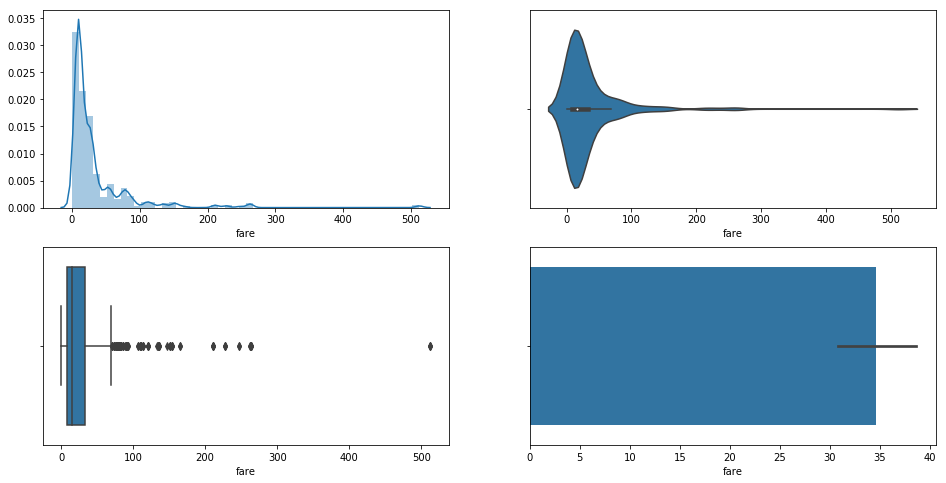

In [8]:
# Your code here
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
sns.distplot(titanic.fare, ax=axes[0,0]) # pdf of univariate distributions
sns.violinplot(x='fare', data=titanic, ax=axes[0,1])
sns.boxplot(x='fare', data=titanic, ax=axes[1,0])
sns.barplot(x='fare', data=titanic, ax=axes[1,1])
# Of course you should label your axes, etc.

What do we learn from each visualization? Which is most helpful?

What can we say about the fares that passengers paid?

**Your answer here**
A good visualization of the distribution of a variable will enable us to answer three kinds of questions:

- What values are central or typical? (e.g., mean, median, modes)
- What is the typical spread of values around those central values? (e.g., variance/stdev, skewness)
- What are unusual or exceptional values (e.g., outliers)

The barplot clearly shows the mean and stdev, but that's about it. The other visualizations give complementary info, e.g., the boxplot shows outliers clearly, but the histogram most clearly suggests that there might be secondary modes in addition to the primary mode.

Overall, we can see that most passengers paid below $50, but there are many outliers. If we were carefully analyzing this data, we might consider removing some outliers entirely and transforming the remaining data to make its distribution more Normal. But for now we'll just use the data as-is.

### Exploring predictors

Cabin class is probably going to matter for fare, but we might wonder if age and gender also matter. Let's explore them.

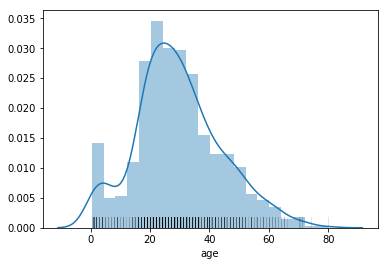

In [9]:
# adds a small line (rug) at the bottom for every point, so it gets darker for more points at same age
sns.distplot(titanic.age, rug=True, rug_kws={'alpha': .1, 'color': 'k'})

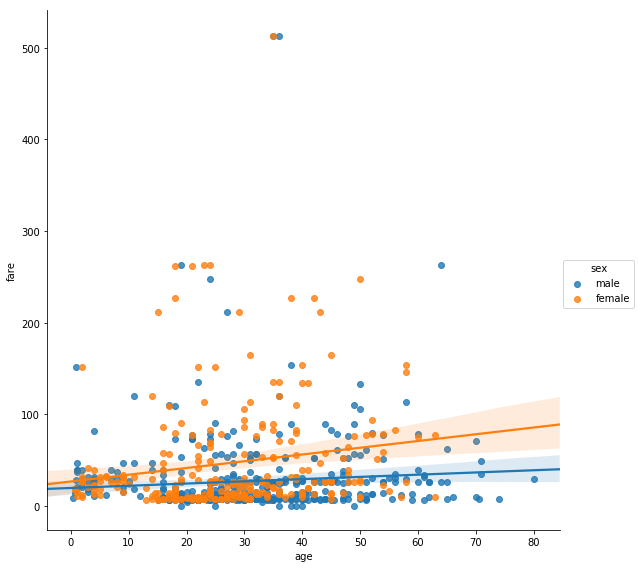

In [10]:
# lmplot could be helpful to determine whether we need interaction terms or not
sns.lmplot(x="age", y="fare", hue="sex", data=titanic, size=8)

Hmm... the slopes seem to be different for males and females. Remember this for later.

How about sex and class?

In [11]:
titanic.sex.value_counts()

male      453
female    259
Name: sex, dtype: int64

In [12]:
titanic['class'].value_counts()
# Why couldn't we write `titanic.class.value_counts()` here? -- 'class' is also a keyword in python.

Third     355
First     184
Second    173
Name: class, dtype: int64

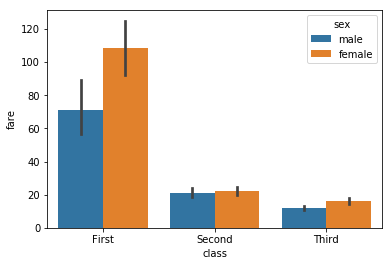

In [13]:
sns.barplot(x="class", hue="sex", y="fare", data=titanic)

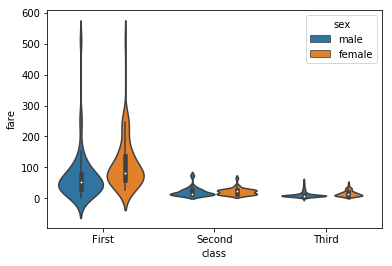

In [14]:
sns.violinplot(x="class", hue="sex", y="fare", data=titanic)

## Aside: can we replicate that violin plot without Seaborn?

{'bodies': [<matplotlib.collections.PolyCollection at 0xc8934711d0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0xc893471128>,
 'cmins': <matplotlib.collections.LineCollection at 0xc893471b70>,
 'cbars': <matplotlib.collections.LineCollection at 0xc893471e48>}

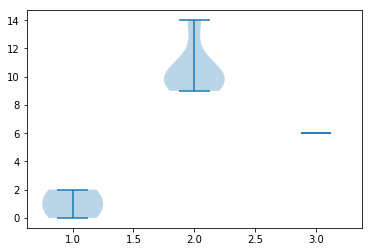

In [15]:
# plt.violinplot takes an array of data arrays, and plots each one as a separate violin.
# The data arrays don't have to be the same length.
# It returns Matplotlib objects corresponding to each of the pieces of the visualization.
plt.violinplot([
    [0,1,2], 
    [10, 14, 9, 10, 10, 10],
    [6]
])

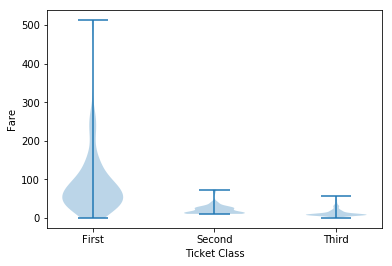

In [16]:
# We can use Pandas queries to make datasets for each class.
# We need to use `.values` to get plain Numpy arrays.
classes = 'First Second Third'.split()
plt.violinplot([
    titanic['fare'][titanic['class'] == cls].values
    for cls in classes
])
plt.xticks([1,2,3], classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

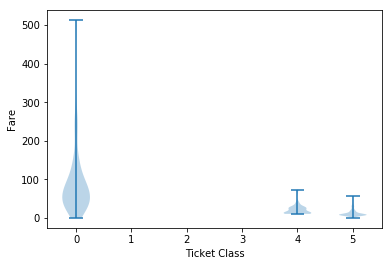

In [17]:
# It gets a little more tricky when we want to plot the two sexes side-by-side.
# Fortunately we can tell violinplot to place the violins at different positions.
position_array = [0, 4, 5] # just to show the effect of the position array.
plt.violinplot([
    titanic['fare'][titanic['class'] == cls].values
    for cls in classes
], positions=position_array)
#plt.xticks(position_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

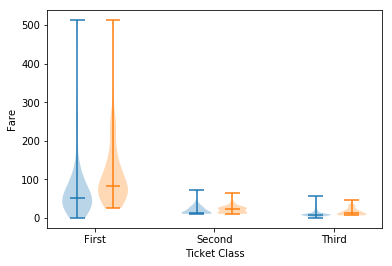

In [18]:
# We can use the position array to shift the male and female violins.

sexes = 'male female'.split()
positions_array = np.arange(len(classes)) # this will be [0, 1, 2]
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

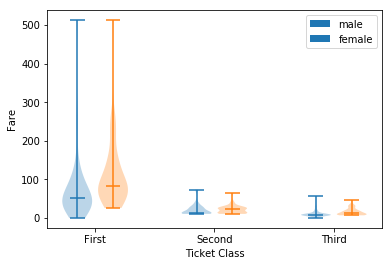

In [19]:
# But what about a legend? Unfortunately plt.violinplot doesn't support legends, so we
# have to do it by hand.
positions_array = np.arange(len(classes))
fake_handles = []
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
    fake_handles.append(mpatches.Patch())
plt.legend(fake_handles, sexes)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

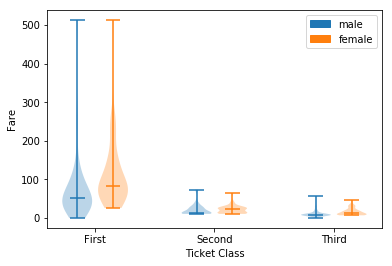

In [20]:
# Dang, the colors are wrong. We'll have to use some hacky code to pull the color out of the violin...
positions_array = np.arange(len(classes))
fake_handles = []
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
    cur_violin_color = violin['cbars'].get_color()[0]
    fake_handles.append(mpatches.Patch(color=cur_violin_color))
plt.legend(fake_handles, sexes)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

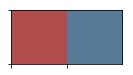

In [21]:
# Or explicitly control the colors.
colors = sns.color_palette("Set1", n_colors=len(sexes), desat=.5)
sns.palplot(colors)

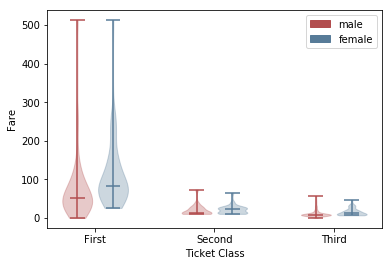

In [22]:
positions_array = np.arange(len(classes))
fake_handles = []
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)

    # Set the color
    color = colors[i]
    for part_name, part in violin.items():
        if part_name == 'bodies':
            for body in violin['bodies']:
                body.set_color(color)
        else:
            part.set_color(color)
    fake_handles.append(mpatches.Patch(color=color))

plt.legend(fake_handles, sexes)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

## No more digression, back to regressions.

So it looks like fare varies with class, age, and maybe gender, and the way that fare depends on class and age may be different for male vs female.

Let's first do a simple linear regression on age.

In [23]:
model1 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic['age'])
).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.214
Date:                Thu, 04 Oct 2018   Prob (F-statistic):             0.0129
Time:                        20:20:38   Log-Likelihood:                -3832.7
No. Observations:                 712   AIC:                             7669.
Df Residuals:                     710   BIC:                             7679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4823      4.503      5.437      0.000      15.642      33.323
age            0.3402      0.136      2.493      0.013       0.072       0.608
==============================================================================
Omnibus:                      715.959   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30912.718
Skew:                           4.664   Prob(JB):                         0.00
Kurtosis:                      33.903   Cond. No.                         75.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

How do we interpret this?

* How good is this model?
* Does age affect fare? How can we tell? And if so, how?

### Handling categorical variables

Statistical packages generally distinguish between three types of variables:

* **continuous** variables, like age and fare.
* **nominal** variables, like gender and whether the person survived
* **ordinal** variables like cabin class (first > second > third)

(Ordinal variables can often be treated like nominal variables; that's what we'll do for now.)

How do we deal with gender, or class? They're categorical variables. We'll need to use dummy variables to encode them.

In [24]:
titanic_orig = titanic.copy()

<div class="exercise">**Exercise 2**: Create a column `sex_male` that is 1 if the passenger is male, 0 otherwise.</div>

In [25]:
# Your code here
titanic['sex_male'] = (titanic.sex == 'male').astype(int)

<div class="exercise">**Exercise 3**: Do we need a `sex_female` column, or any others? Why or why not?</div>

**your answer here**

No, because it's redundant: the only values for `sex` in this dataset are `male` and `female`, so if a passenger is not male, we know they're female.

<div class="exercise">**Exercise 4**: Create columns for `class_`</div>

In [29]:
# Your code here
titanic['class_Second'] = (titanic['class'] == 'Second').astype(int)
titanic['class_Third'] = 1 * (titanic['class'] == 'Third') # just another way to convert it to integer

In [30]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 9 columns):
age             712 non-null float64
sex             712 non-null object
class           712 non-null category
embark_town     712 non-null object
alone           712 non-null bool
fare            712 non-null float64
sex_male        712 non-null int32
class_Second    712 non-null int32
class_Third     712 non-null int32
dtypes: bool(1), category(1), float64(2), int32(3), object(2)
memory usage: 57.6+ KB


In [32]:
# Your code here
# This function automates the above:
titanic = pd.get_dummies(titanic_orig, columns=['sex', 'class'], drop_first=True)
titanic.head()

,age,embark_town,alone,fare,sex_male,class_Second,class_Third
0,22.0,Southampton,False,7.2500,1,0,1
1,38.0,Cherbourg,False,71.2833,0,0,0
2,26.0,Southampton,True,7.9250,0,0,1
3,35.0,Southampton,False,53.1000,0,0,0
4,35.0,Southampton,True,8.0500,1,0,1


<div class="exercise">**Exercise 5**: Fit a linear regression including the new sex and class variables.</div>

In [33]:
# Your code here
model2 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third']])
).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     110.9
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           2.25e-73
Time:                        20:31:02   Log-Likelihood:                -3662.4
No. Observations:                 712   AIC:                             7335.
Df Residuals:                     707   BIC:                             7358.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          110.9658      5.485     20.229      0.000     100.196     121.736
age             -0.4513      0.117     -3.841      0.000      -0.682      -0.221
sex_male       -10.4196      3.329     -3.130      0.002     -16.956      -3.883
class_Second   -70.0469      4.515    -15.514      0.000     -78.911     -61.182
class_Third    -78.9638      4.145    -19.051      0.000     -87.102     -70.826
==============================================================================
Omnibus:                      804.007   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70017.197
Skew:                           5.349   Prob(JB):                         0.00
Kurtosis:                      50.388   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class='exercise'> **Exercise 6** How do we interpret these results?</div>
* All else being equal, what does being male do to the fare?
* What can we say about being *male* and *first-class*?


** Your answer here **

## Interactions

In [35]:
# It seemed like gender interacted with age and class. Can we put that in our model?
# interaction term 'sex_male_X_age' will be negative, because it will be difference from sex = female (or the baseline 
#will be female) and that had higher fare if we look at the lmplot above
titanic['sex_male_X_age'] = titanic['age'] * titanic['sex_male']
model3 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age']])
).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     90.21
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           2.26e-73
Time:                        20:43:21   Log-Likelihood:                -3659.9
No. Observations:                 712   AIC:                             7332.
Df Residuals:                     706   BIC:                             7359.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            101.7891      6.868     14.821      0.000      88.305     115.273
age               -0.1195      0.190     -0.628      0.530      -0.493       0.254
sex_male           4.0310      7.334      0.550      0.583     -10.367      18.429
class_Second     -70.2038      4.503    -15.590      0.000     -79.045     -61.362
class_Third      -78.9242      4.134    -19.093      0.000     -87.040     -70.809
sex_male_X_age    -0.5030      0.228     -2.210      0.027      -0.950      -0.056
==============================================================================
Omnibus:                      808.727   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71826.587
Skew:                           5.397   Prob(JB):                         0.00
Kurtosis:                      51.006   Cond. No.                         241.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

** What happened to the `age` and `male` terms? **

In [38]:
# It seemed like gender interacted with age and class. Can we put that in our model?
titanic['sex_male_X_class_Second'] = titanic['age'] * titanic['class_Second']
titanic['sex_male_X_class_Third'] = titanic['age'] * titanic['class_Third']
model4 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic[['age', 'sex_male', 'class_Second', 'class_Third', 'sex_male_X_age', 'sex_male_X_class_Second', 'sex_male_X_class_Third']])
).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   fare   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     67.80
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           1.23e-74
Time:                        20:45:20   Log-Likelihood:                -3652.4
No. Observations:                 712   AIC:                             7321.
Df Residuals:                     704   BIC:                             7357.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     127.2774      9.446     13.474      0.000     108.732     145.823
age                        -0.7991      0.257     -3.107      0.002      -1.304      -0.294
sex_male                    4.0819      7.266      0.562      0.574     -10.185      18.348
class_Second             -104.1076     11.219     -9.280      0.000    -126.134     -82.081
class_Third              -112.1375      9.787    -11.458      0.000    -131.352     -92.923
sex_male_X_age             -0.4864      0.226     -2.156      0.031      -0.929      -0.043
sex_male_X_class_Second     0.9504      0.305      3.120      0.002       0.352       1.549
sex_male_X_class_Third      0.9728      0.270      3.602      0.000       0.443       1.503
==============================================================================
Omnibus:                      812.510   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75162.969
Skew:                           5.424   Prob(JB):                         0.00
Kurtosis:                      52.152   Cond. No.                         445.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What has happened to the $R^2$ as we added more features? Does this mean that the model is better? (What if we kept adding more predictors and interaction terms? We'll explore this in the next homework.)

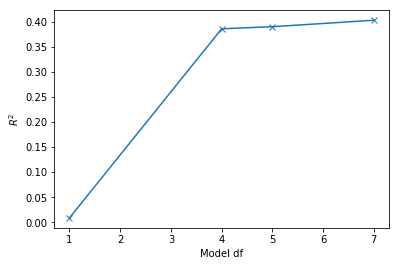

In [39]:
models = [model1, model2, model3, model4]
plt.plot([model.df_model for model in models], [model.rsquared for model in models], 'x-')
plt.xlabel("Model df")
plt.ylabel("$R^2$");

## 2. Model Selection via exhaustive search selection

The dataset for this problem contains 10 simulated predictors and a response variable. 

In [40]:
# Import the dataset
data = pd.read_csv('data/dataset3.txt')
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.488866,0.488866,0.488866,0.078913,0.098292,0.144871,0.065302,0.250225,-0.392509,-0.501255,0.625915
1,0.146479,0.146479,0.146479,0.022562,0.088052,0.104879,0.082436,0.332836,-0.178366,-0.061798,0.058947
2,0.525450,0.525450,0.525450,-0.157520,-0.328685,-0.246146,-0.233882,0.054153,-0.010547,0.393186,-0.176577
3,0.351241,0.351241,0.351241,-0.062256,-0.096287,-0.033425,-0.088843,-0.475510,-0.066429,-0.249999,0.154168
4,-0.168068,-0.168068,-0.168068,-0.080250,-0.155529,-0.099511,-0.106430,-0.203144,0.194485,-0.037681,-0.288597


**By visually inspecting the data set, do we find that some of the predictors are correlated amongst themselves?**

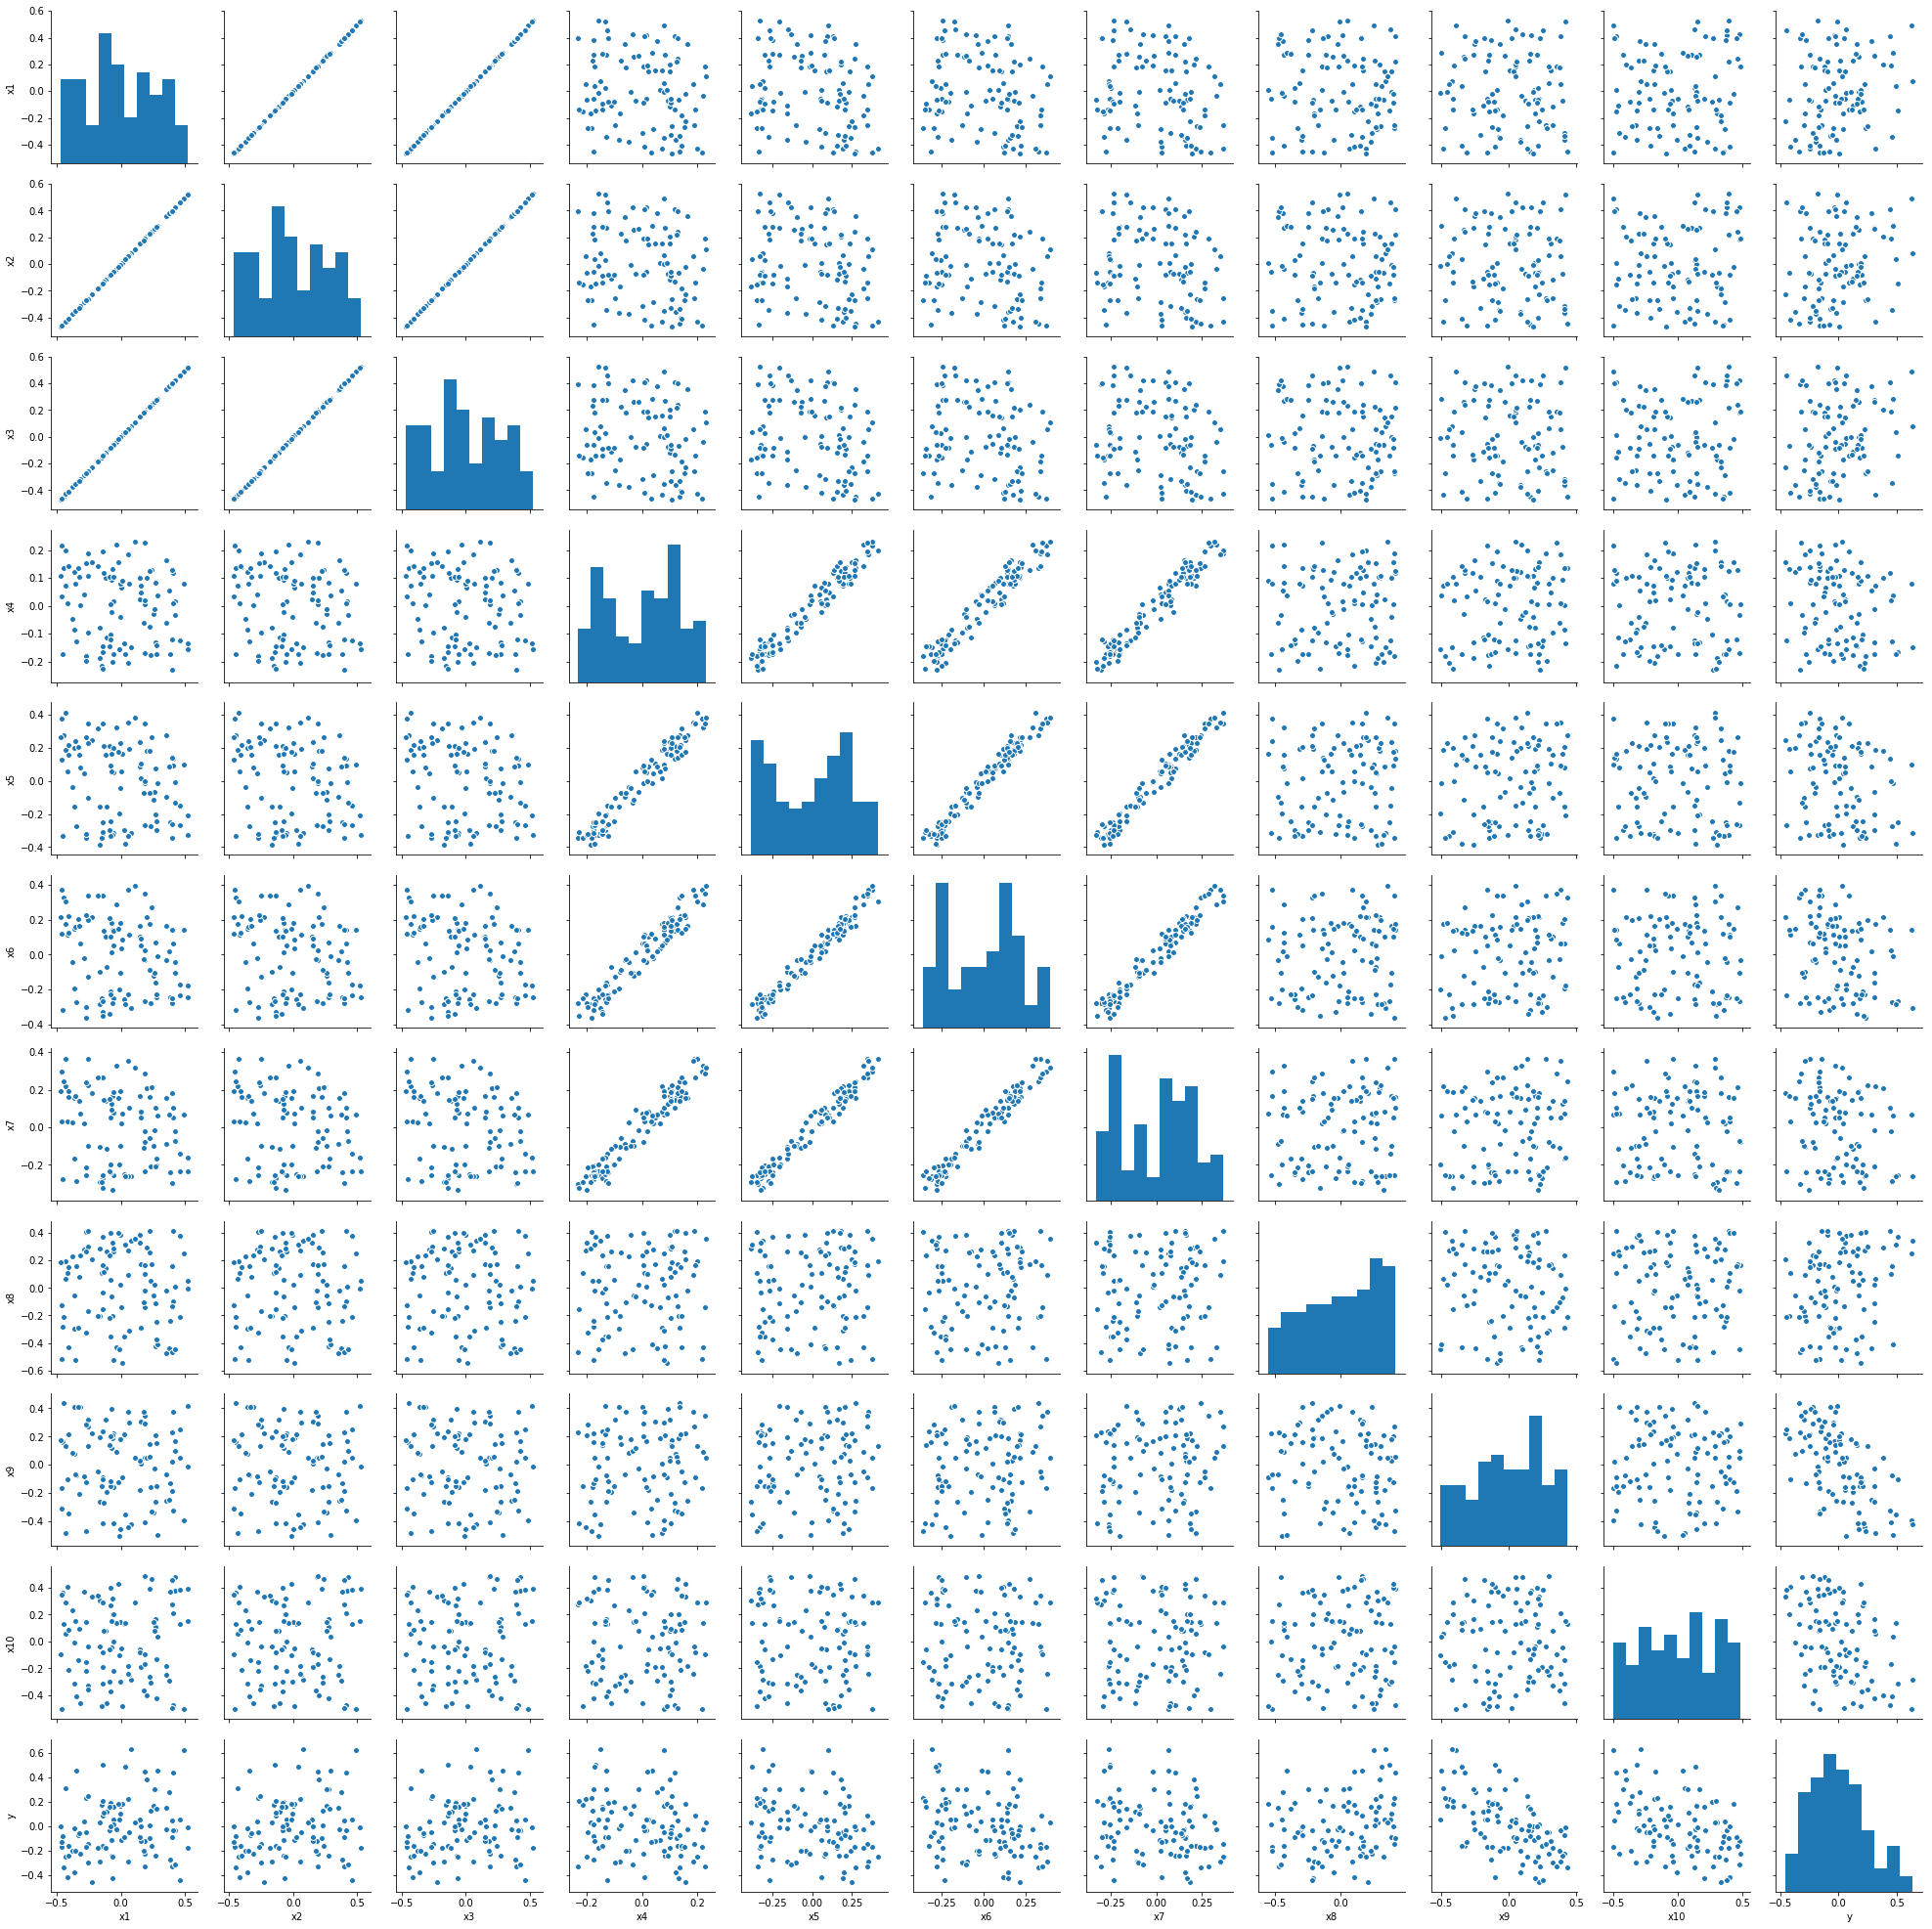

In [41]:
sns.pairplot(data)

Predictors x1, x2, x3 seem to be perfectly correlated while predictors x4, x5, x6, x7 show very high degrees of correlation.

In [42]:
data.corr()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
x1,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x2,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x3,1.000000,1.000000,1.000000,-0.189945,-0.232439,-0.215623,-0.228322,-0.047643,-0.061022,0.050977,0.195962
x4,-0.189945,-0.189945,-0.189945,1.000000,0.974279,0.964344,0.969540,0.058516,0.108294,-0.010416,-0.225856
x5,-0.232439,-0.232439,-0.232439,0.974279,1.000000,0.982785,0.982227,0.080342,0.126004,-0.012399,-0.257433
x6,-0.215623,-0.215623,-0.215623,0.964344,0.982785,1.000000,0.976308,0.079547,0.123368,-0.021029,-0.261228
x7,-0.228322,-0.228322,-0.228322,0.969540,0.982227,0.976308,1.000000,0.074004,0.112241,-0.022023,-0.235921
x8,-0.047643,-0.047643,-0.047643,0.058516,0.080342,0.079547,0.074004,1.000000,-0.133182,0.052151,0.238538
x9,-0.061022,-0.061022,-0.061022,0.108294,0.126004,0.123368,0.112241,-0.133182,1.000000,0.006923,-0.607845
x10,0.050977,0.050977,0.050977,-0.010416,-0.012399,-0.021029,-0.022023,0.052151,0.006923,1.000000,-0.406231


Let us compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. 

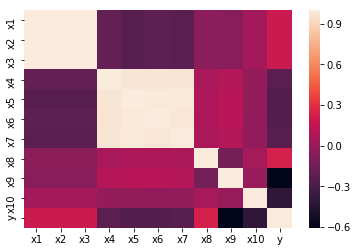

In [43]:
# generating heat map
sns.heatmap(data.corr())

**Do the predictors fall naturally into groups based on the correlation values?**

We can see that higly correlated predictors fall into dark red groups based on correlation values close to 1. Other correlation values also form differently coloured groups.

<div class="exercise">**If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? **</div>

** Your answer here **
We may choose one predictor from the x1,x2,x3 list - let's pick x1. <br/>
Similarly, let's pick x6 out of x4,x5,x6,x7. <br/>
The other predictors are not strongly correlated, so we pick them all, i.e. x8,x9,x10. <br/>
Thus, we have picked 5 predictors x1, x6, x8, x9, x10 for our regression model. 

### Model Selection Criteria: Bayesian Information Criterion (BIC)

Generally BIC = -2 x Log-likehood + 2 x log(K)

For least-squares regression specifically,

$$BIC = n \log \Big(\frac{RSS}{n}\Big) + \log(n)*K$$

where, <br/>
RSS = Residual Sum of Squares <br/>
n = the number of obervations <br/>
K = the number of features in our model

### Selecting minimal subset of predictors

Let us apply the exhaustive search variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy. We will use the Bayesian Information Criterion (BIC) to choose the subset size.

In [44]:
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
x.shape, y.shape

((100, 10), (100,))

In [45]:
def find_best_subset_of_size(x, y, num_predictors):
    predictors = x.columns
    
    best_r_squared = -np.inf
    best_model_data = None

    # Enumerate subsets of the given size
    subsets_of_size_k = itertools.combinations(predictors, num_predictors)

    # Inner loop: iterate through subsets_k
    for subset in subsets_of_size_k:

        # Fit regression model using ‘subset’ and calculate R^2 
        # Keep track of subset with highest R^2

        features = list(subset)
        x_subset = sm.add_constant(x[features])

        model = sm.OLS(y, x_subset).fit()
        r_squared = model.rsquared

        # Check if we get a higher R^2 value than than current max R^2.
        # If so, update our best subset 
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_model_data = {
                'r_squared': r_squared,
                'subset': features,
                'model': model
            }
    return best_model_data

In [46]:
find_best_subset_of_size(x, y, 8)

{'r_squared': 0.6445570800123953,
 'subset': ['x1', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'],
 'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0xc89ba05898>}

In [47]:
def exhaustive_search_selection(x, y):
    """Exhaustively search predictor combinations

    Parameters:
    -----------
    x : DataFrame of predictors/features
    y : response varible 
    
    
    Returns:
    -----------
    
    Dataframe of model comparisons and OLS Model with 
    lowest BIC for subset with highest R^2
    
    """
    
    predictors = x.columns
    
    stats = []
    models = dict()
    
    # Outer loop: iterate over sizes 1, 2 .... d
    for k in range(1, len(predictors)):
        
        best_size_k_model = find_best_subset_of_size(
            x, y, num_predictors=k)
        best_subset = best_size_k_model['subset']
        best_model = best_size_k_model['model']
        
        stats.append({
            'k': k,
            'formula': "y ~ {}".format(' + '.join(best_subset)),
            'bic': best_model.bic,
            'r_squared': best_model.rsquared
        })
        models[k] = best_model
        
    return pd.DataFrame(stats), models

In [48]:
stats, models = exhaustive_search_selection(x, y)
stats

,bic,formula,k,r_squared
0,-36.720144,y ~ x9,1,0.369475
1,-61.732380,y ~ x9 + x10,2,0.531105
2,-65.728760,y ~ x6 + x9 + x10,3,0.569751
3,-71.007523,y ~ x6 + x8 + x9 + x10,4,0.610243
4,-72.366019,y ~ x1 + x6 + x8 + x9 + x10,5,0.632807
5,-70.354782,y ~ x1 + x4 + x6 + x8 + x9 + x10,6,0.642209
6,-66.158687,y ~ x1 + x4 + x6 + x7 + x8 + x9 + x10,7,0.643670
7,-61.802744,y ~ x1 + x4 + x5 + x6 + x7 + x8 + x9 + x10,8,0.644557
8,-61.802744,y ~ x1 + x2 + x4 + x5 + x6 + x7 + x8 + x9 + x10,9,0.644557


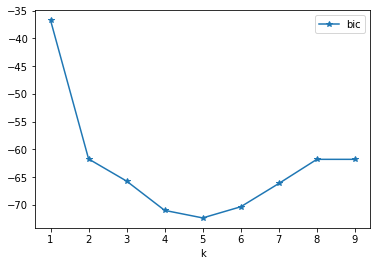

In [49]:
stats.plot(x='k', y='bic', marker='*')

In [50]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
bic          9 non-null float64
formula      9 non-null object
k            9 non-null int64
r_squared    9 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 368.0+ bytes


In [51]:
best_stat = stats.iloc[stats.bic.idxmin()]
best_stat

bic                              -72.366
formula      y ~ x1 + x6 + x8 + x9 + x10
k                                      5
r_squared                       0.632807
Name: 4, dtype: object

In [52]:
best_k = best_stat['k']
best_bic = best_stat['bic']
best_formula = best_stat['formula']
best_r2 = best_stat['r_squared']

In [53]:
print("The best overall model is `{formula}` with bic={bic:.2f} and R^2={r_squared:.3f}".format(
    formula=best_formula, bic=best_bic, r_squared=best_r2))

The best overall model is `y ~ x1 + x6 + x8 + x9 + x10` with bic=-72.37 and R^2=0.633


In [54]:
models[best_k].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     32.40
Date:                Thu, 04 Oct 2018   Prob (F-statistic):           4.59e-19
Time:                        22:30:30   Log-Likelihood:                 49.999
No. Observations:                 100   AIC:                            -88.00
Df Residuals:                      94   BIC:                            -72.37
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.337e-18      0.015   2.86e-16      1.000      -0.030       0.030
x1             0.1343      0.056      2.403      0.018       0.023       0.245
x6            -0.2147      0.074     -2.883      0.005      -0.363      -0.067
x8             0.1810      0.055      3.312      0.001       0.073       0.290
x9            -0.5081      0.059     -8.545      0.000      -0.626      -0.390
x10           -0.3584      0.053     -6.782      0.000      -0.463      -0.254
==============================================================================
Omnibus:                       28.643   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.697
Skew:                           0.051   Prob(JB):                       0.0579
Kurtosis:                       1.835   Cond. No.                         5.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Do the chosen subsets match the ones you picked using the correlation matrix you had visualized?**

Yes! The predictor subset matches with the ones we picked before.

## Plotting multiple axes in a single figure

![](https://i.imgur.com/XTzSuoR.png)
source: http://matplotlib.org/faq/usage_faq.html

See also [this](http://matplotlib.org/faq/usage_faq.html) matplotlib tutorial.